# N-beats model의 이해

---

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.callbacks import EarlyStopping

---

## contributions

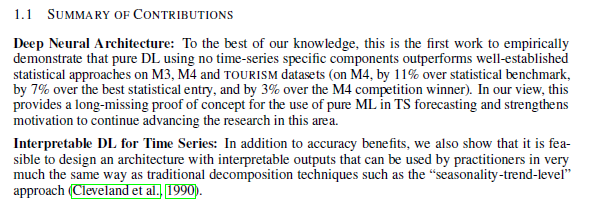

- 순수한 딥러닝 방법이 통계적 접근 방식보다 타임시리즈 예측의 벤치마크가 더 높았음 따라서 time series의 예측을 위한 순수 ML 연구의 동기을 얻을 수 있음
- time seires를 전통적인 분해법과 같은 해석가능한 유연한 딥러닝 아키텍쳐를 제공해주었음

---

## n-beats

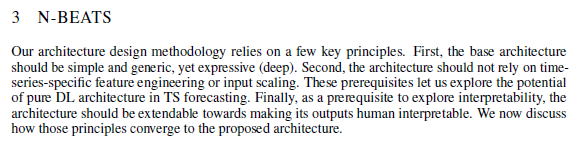

- n-beats의 모델 디자인은 몇가지의 원칙에 의존
    1. 기초 아키텍쳐는 간단하고 generic함
    2. 이 아키텍쳐는 time series의 특정 변수 엔지니어링이나 input scaling에 의존하지 않음ㅈ
    3. 이 아키텍쳐는 해석이 가능하게끔 확장될 수 있음

---

## basic block

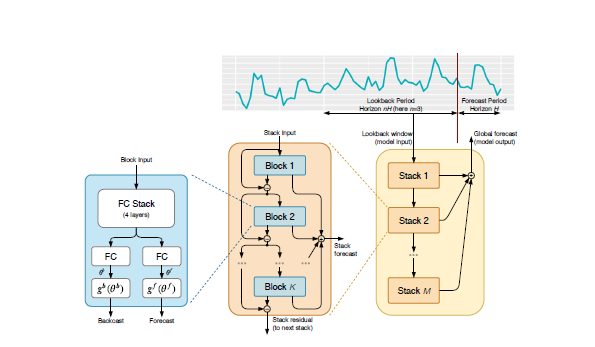
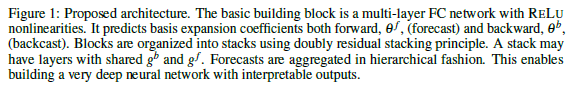

- basic block은 포크 형태의 아키텍쳐를 가짐
- frist block은 특정 길이의 관측된 window만큼의 $x$를 반영함
- multiple of the forecast horizon H만큼의 input window 길이를 설정함 
- block은 input x를 받아들이고 $\hat{x}, \hat{y}$를 output으로 내놓는다
    - $\hat{x}$는 실제 $x$와 가장 잘 추정한 것을 내놓고
    - $\hat{y}$는 블락에서 설정한 H의 길이만큼을 내놓음
- 나머지 블락은 앞서 블락이 내놓은 residual output을 input으로 삼는다.

`-` input x가 first block을 통과하고 다음 블락에게 전달하는 과정
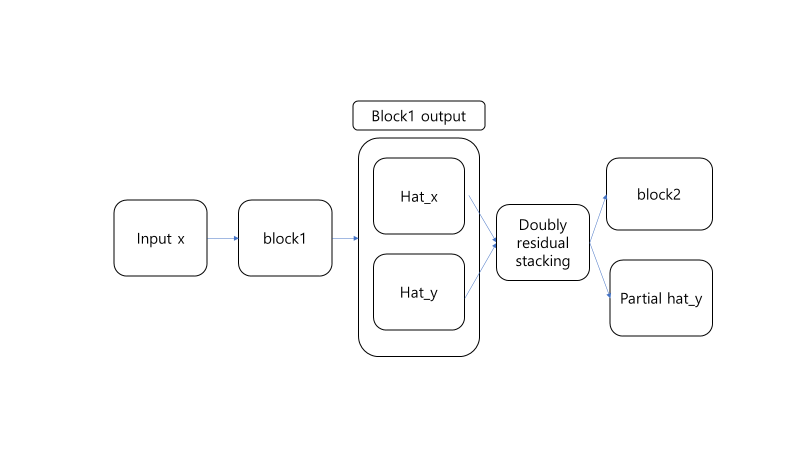)

`-` basic모델 구성

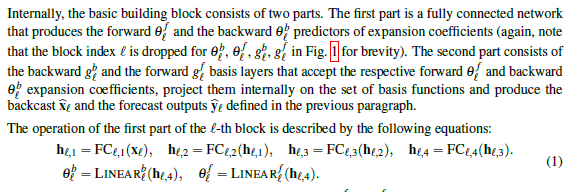

- 베이직 모델은 크게 2개의 part로 구분되어 있다
    - first part(RELU) : fully connnected network로 구성되었고 expansion coefficients의 예측자인 forward $\theta$와 backward $\theta$를 내놓는다
    - second part(Linear) : backward g함수와 forward g함수로 구성되어있어 앞서 첫번째 파트에서 나온 \theta를 받아들이고 최종적으로 output을 내놓는다

---

## generic block 구현

`-` 연습용 데이터

In [271]:
t = np.linspace(1,10,1000)
X =  t+ np.sin(4*t*np.pi)
y = X+np.cos(t)
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
scale_X= minmax.fit_transform(X.reshape(-1, 1)) # input
scale_y= minmax.fit_transform(y.reshape(-1, 1)) # putput

from sklearn.model_selection import train_test_split
train_x, test_x, train_y,test_y = train_test_split(scale_X,scale_y,shuffle=False)


In [258]:
train_x.shape, train_y.shape,test_x.shape,test_y.shape

((750, 1), (750, 1), (250, 1), (250, 1))

---

### `-` generic block model

In [285]:
backcast_length,horizen = 1,1
feature1 = 1
unit = 128
theta_dim1,theta_dim2= 1,1
forecast_length = horizen

K.clear_session()
d0 = Input(shape=(horizen , feature1))
d1 = Dense(unit,activation = 'relu')(d0)
d2 = Dense(unit,activation = 'relu')(d1)
d3 = Dense(unit,activation = 'relu')(d2)
d4 = Dense(unit,activation = 'relu')(d3)

theta_b = Dense(theta_dim1, activation='linear', name='theta_b')(d4)
theta_f = Dense(theta_dim2, activation='linear',  name='theta_f')(d4)

backcast = Dense(backcast_length, activation='linear', use_bias=False,name='backcast')(theta_b)
forecast = Dense(forecast_length, activation='linear', use_bias=False,name='forecast')(theta_f)

block = Model(inputs=d0, outputs = [backcast,forecast])
optimizer = Adam(learning_rate=0.0001)
block.compile(optimizer=optimizer, loss='mean_squared_error')
block.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 1, 128)       256         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 1, 128)       16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 1, 128)       16512       ['dense_1[0][0]']                
                                                                                              

In [286]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
epochs = 50
batch_size = 2

block.fit(train_x,[train_x,train_y], epochs=epochs, batch_size=2,callbacks=[early_stop])
          

Epoch 1/50
375/375 [==============================] - 1s 856us/step - loss: 0.1457 - backcast_loss: 0.1185 - forecast_loss: 0.0272
Epoch 2/50
375/375 [==============================] - 0s 861us/step - loss: 0.0055 - backcast_loss: 0.0022 - forecast_loss: 0.0033
Epoch 3/50
375/375 [==============================] - 0s 864us/step - loss: 0.0028 - backcast_loss: 2.7359e-04 - forecast_loss: 0.0025
Epoch 4/50
375/375 [==============================] - 0s 863us/step - loss: 0.0028 - backcast_loss: 5.3695e-05 - forecast_loss: 0.0028
Epoch 5/50
375/375 [==============================] - 0s 859us/step - loss: 0.0026 - backcast_loss: 4.2857e-05 - forecast_loss: 0.0026
Epoch 6/50
375/375 [==============================] - 0s 869us/step - loss: 0.0024 - backcast_loss: 3.9441e-05 - forecast_loss: 0.0024
Epoch 7/50
375/375 [==============================] - 0s 859us/step - loss: 0.0026 - backcast_loss: 4.0449e-05 - forecast_loss: 0.0026
Epoch 8/50
375/375 [==============================] - 0s 866us/

In [301]:
pred = block.predict(train_x)

24/24 [==============================] - 0s 783us/step


### `-` backcast

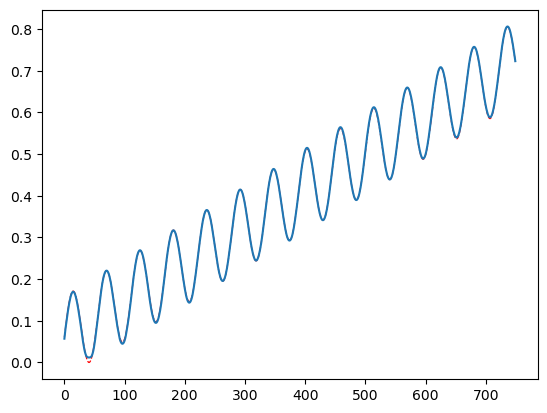

In [303]:
plt.plot(train_x, color = 'red',linewidth=0.9, linestyle='--')
plt.plot(pred[0].flatten())

### `-` forecast

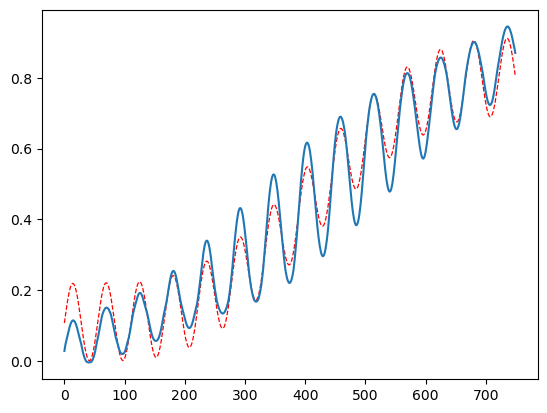

In [304]:
plt.plot(train_y, color = 'red',linewidth=0.9, linestyle='--')
plt.plot(pred[1].flatten())
